In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps


In [2]:
%matplotlib inline

In [3]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import cv2

import torch

In [4]:
from src.data.dataloader_light import nuScenesMaps, read_split

from argslib import parse_args, init
from visualization import color_components, make_composite, plot_ground_truth, COLOR_MAP, color_map_labels, visualize_prediction

In [5]:
args = parse_args(notebook=True)
args.root = '/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-trainval_meta/'
args.val_split = 'evaluation'
init(args)

In [7]:
res_100 = torch.load('experiments/tiim_28k-exp6/inference_results//ckpt-26-val-pred-100x100.pt')

In [8]:
val_data = nuScenesMaps(
        root=args.root,
        split=args.val_split,
        grid_size=args.grid_size,
        grid_res=args.grid_res,
        classes=args.load_classes_nusc,
        dataset_size=args.data_size,
        desired_image_size=args.desired_image_size,
        mini=True,
        gt_out_size=(100, 100),
        nusc_data_file='eval_data.pickle'
    )

/Users/deepakduggirala/miniforge3/envs/tim/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1670076285409/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


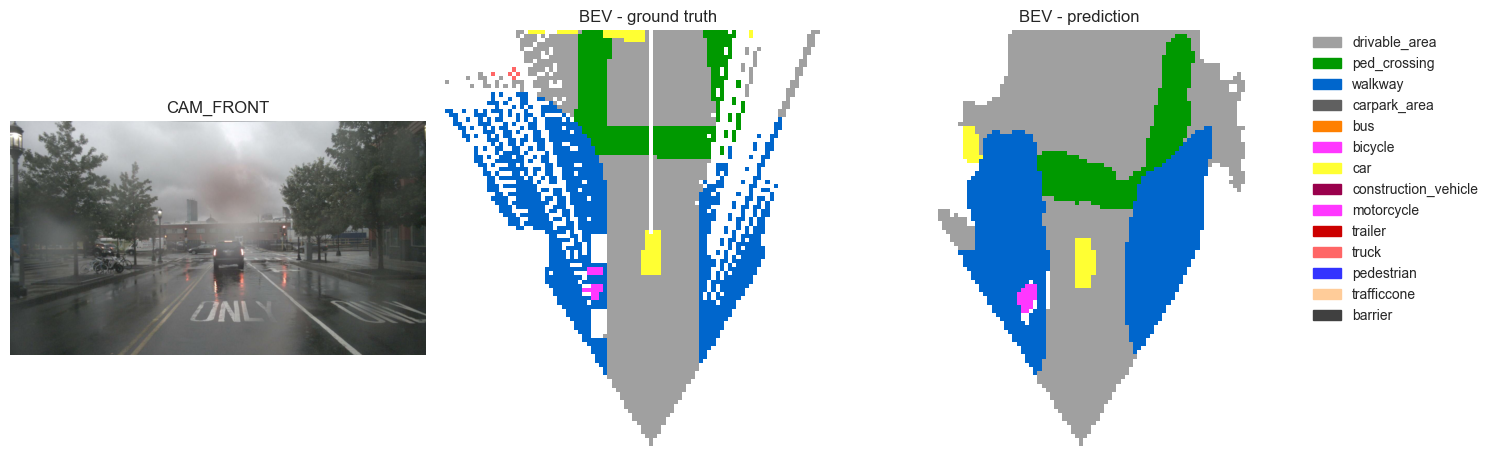

In [9]:
i_sample = 0
image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(i_sample)
pred = res_100[i_sample]
visualize_prediction(image, cls_maps, pred, figsize=(15, 10))

In [10]:
pred.shape, cls_maps.shape, vis_mask.shape

(torch.Size([14, 100, 100]),
 torch.Size([14, 100, 100]),
 torch.Size([1, 100, 100]))

In [97]:
pred_proba = torch.sigmoid(pred)
pred_proba_masked = pred_proba * vis_mask.float()
pred_proba_masked_thresh = pred_proba_masked > 0.5

In [107]:
label_masked = cls_maps * vis_mask.float()
label_masked_thresh = label_masked > 0.5

In [108]:
intersection = pred_proba_masked_thresh * label_masked_thresh
union = pred_proba_masked_thresh + label_masked_thresh

In [118]:
iou_per_class = (intersection.float().sum(dim=-1).sum(dim=-1)) / (
                union.float().sum(dim=-1).sum(dim=-1) + 1e-5
        )
iou_per_class

tensor([0.8655, 0.0281, 0.5618, 0.0000, 0.0000, 0.2632, 0.2745, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [125]:
torch.mean(iou_per_class)

tensor(0.1424)

In [120]:
class_count = label_masked_thresh.sum(dim=-1).sum(dim=-1)
class_count[class_count > 0] = 1
class_count

tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [122]:
iou_per_class.sum(dim=0)

tensor(1.9931)

In [123]:
class_count.sum(dim=0)

tensor(7)

In [124]:
iou_per_class.sum(dim=0) / class_count.sum(dim=0)

tensor(0.2847)

In [129]:
def compute_iou(pred, cls_maps, vis_mask):
    pred_proba = torch.sigmoid(pred)
    pred_proba_masked = pred_proba * vis_mask.float()
    pred_proba_masked_thresh = pred_proba_masked > 0.5
    
    label_masked = cls_maps * vis_mask.float()
    label_masked_thresh = label_masked > 0.5
    
    intersection = pred_proba_masked_thresh * label_masked_thresh
    union = pred_proba_masked_thresh + label_masked_thresh
    
    iou_per_class = (intersection.float().sum(dim=-1).sum(dim=-1)) / (union.float().sum(dim=-1).sum(dim=-1) + 1e-5)
    
    class_count = label_masked_thresh.sum(dim=-1).sum(dim=-1)
    class_count[class_count > 0] = 1
    
    num_classes = class_count.sum(dim=0)
    iou_per_sample = iou_per_class.sum(dim=0) / num_classes
    
    return iou_per_class, iou_per_sample

In [130]:
compute_iou(pred, cls_maps, vis_mask)

(tensor([0.8655, 0.0281, 0.5618, 0.0000, 0.0000, 0.2632, 0.2745, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]),
 tensor(0.2847))

In [148]:
def dice_loss(pred, labels):
    pred_proba = torch.sigmoid(pred)
    intersection = 2 * pred_proba * cls_maps.float()
    union = pred_proba + cls_maps.float()
    return 1 - (intersection.sum()/(union.sum()+ 1e-5)), 1 - (intersection.sum(dim=-1).sum(dim=-1)/(union.sum(dim=-1).sum(dim=-1)+ 1e-5))




In [149]:
dice_loss(pred, cls_maps)

(tensor(0.3030),
 tensor([0.1629, 0.9575, 0.3716, 1.0000, 1.0000, 0.5907, 0.5557, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

(-0.5, 99.5, 99.5, -0.5)

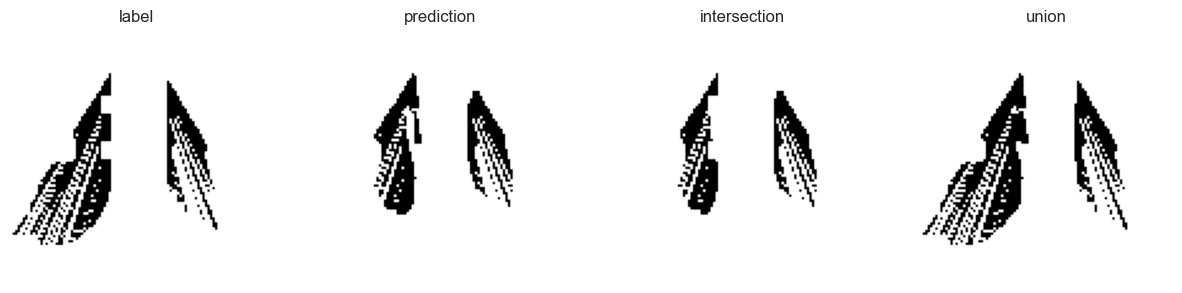

In [168]:
c=2
fig, axs = plt.subplots(ncols=4, figsize=(15, 5))
ax=axs[0]
ax.imshow(label_masked_thresh[c])
ax.set_title('label')
ax.axis('off')

ax=axs[1]
ax.imshow(pred_proba_masked_thresh[c])
ax.set_title('prediction')
ax.axis('off')

ax=axs[2]
ax.imshow(pred_proba_masked_thresh[c] * label_masked_thresh[c])
ax.set_title('intersection')
ax.axis('off')

ax=axs[3]
ax.imshow(pred_proba_masked_thresh[c] + label_masked_thresh[c])
ax.set_title('union')
ax.axis('off')

In [173]:
TP = pred_proba_masked_thresh * label_masked_thresh
FP = pred_proba_masked_thresh * (~label_masked_thresh)
FN = (~pred_proba_masked_thresh) * label_masked_thresh

(-0.5, 99.5, 99.5, -0.5)

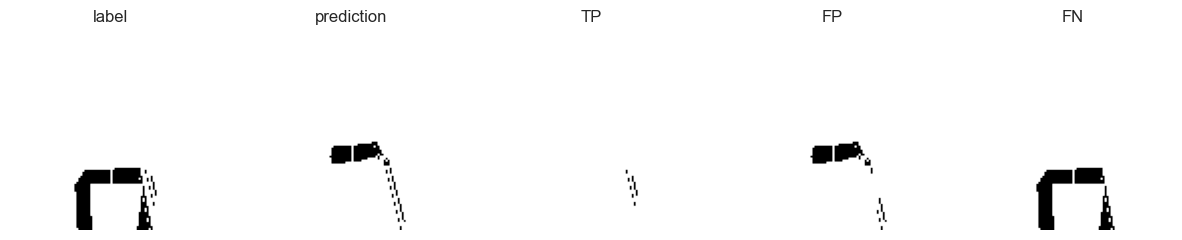

In [176]:
c=1
fig, axs = plt.subplots(ncols=5, figsize=(15, 5))
ax=axs[0]
ax.imshow(label_masked_thresh[c])
ax.set_title('label')
ax.axis('off')

ax=axs[1]
ax.imshow(pred_proba_masked_thresh[c])
ax.set_title('prediction')
ax.axis('off')

ax=axs[2]
ax.imshow(TP[c])
ax.set_title('TP')
ax.axis('off')

ax=axs[3]
ax.imshow(FP[c])
ax.set_title('FP')
ax.axis('off')

ax=axs[4]
ax.imshow(FN[c])
ax.set_title('FN')
ax.axis('off')

In [187]:
def precision(pred, cls_maps, epsilon=1e-5):
    pred_proba = torch.sigmoid(pred)
    pred_proba_masked = pred_proba * vis_mask.float()
    pred_proba_masked_thresh = pred_proba_masked > 0.5
    
    label_masked = cls_maps * vis_mask.float()
    label_masked_thresh = label_masked > 0.5
    
    TP = pred_proba_masked_thresh * label_masked_thresh
    FP = pred_proba_masked_thresh * (~label_masked_thresh)
    FN = (~pred_proba_masked_thresh) * label_masked_thresh
    
    prec = TP.sum(dim=-1).sum(dim=-1)/(TP.sum(dim=-1).sum(dim=-1)+FP.sum(dim=-1).sum(dim=-1)+epsilon)
    
    class_count = label_masked_thresh.sum(dim=-1).sum(dim=-1)
    class_count[class_count > 0] = 1
    
    num_classes = class_count.sum(dim=0)
    return prec.sum()/num_classes, prec

In [188]:
precision(pred, cls_maps)

(tensor(0.3962),
 tensor([0.9130, 0.0830, 0.8611, 0.0000, 0.0000, 0.2941, 0.6222, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]))